<p style="align: center;"><img src="https://static.tildacdn.com/tild6636-3531-4239-b465-376364646465/Deep_Learning_School.png" width="300"></p>

<h3 style="text-align: center;"><b>Физтех-Школа Прикладной математики и информатики (ФПМИ) МФТИ</b></h3>

---

В этом ноутбке будет рассказано об основах машинного обучения.

Что нужно вынести для себя из занятия:
* Синтаксис работы с моделями и трансформерами в sklearn.
* Какие бывают шаги предобработки данных.
* Когда вы решаете ML задачу обязательно надо посмотреть на данные.


### sklearn
В sklearn есть два типа объектов:

1. Estimator -- модель для предсказаний. Есть метод .fit(X, y) и .predict(X)
2. Transformer -- обработчик данных (например нормирование признаков). Есть метод .fit(X) и .transform(X)

## Данные

Данные - информация о приложениях из AppStore. Поставим регрессионную задачу - предсказать рейтинг приложения. 

## Анализ данных

Начнем с самой важной части - посмотрим на данные. 

In [4]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [5]:
# Загрузим данные и посмотрим на небольшую часть
data = pd.read_csv('./AppleStore.csv')
data.head()

,Unnamed: 0,id,track_name,size_bytes,currency,price,rating_count_tot,rating_count_ver,user_rating,user_rating_ver,ver,cont_rating,prime_genre,sup_devices.num,ipadSc_urls.num,lang.num,vpp_lic
0,1,281656475,PAC-MAN Premium,100788224,USD,3.99,21292,26,4.0,4.5,6.3.5,4+,Games,38,5,10,1
1,2,281796108,Evernote - stay organized,158578688,USD,0.00,161065,26,4.0,3.5,8.2.2,4+,Productivity,37,5,23,1
2,3,281940292,"WeatherBug - Local Weather, Radar, Maps, Alerts",100524032,USD,0.00,188583,2822,3.5,4.5,5.0.0,4+,Weather,37,5,3,1
3,4,282614216,"eBay: Best App to Buy, Sell, Save! Online Shop...",128512000,USD,0.00,262241,649,4.0,4.5,5.10.0,12+,Shopping,37,5,9,1
4,5,282935706,Bible,92774400,USD,0.00,985920,5320,4.5,5.0,7.5.1,4+,Reference,37,5,45,1


Выделим фичи из датасета и поделим их на числовые и категориальные. 

In [6]:
num_cols = [
    'size_bytes',
    'price',
    'rating_count_tot',
    'rating_count_ver',
    'sup_devices.num',
    'ipadSc_urls.num',
    'lang.num',
    # Эта фича - не числовая, а порядковая, но мы все равно возьмем ее как числовую для удобства
    'cont_rating',
]

cat_cols = [
    'currency',
    'prime_genre'
]

target_col = 'user_rating'

cols = num_cols + cat_cols + [target_col]

In [7]:
data = data[cols]
# Возраст записан не в виде числа, исправим это, вырезав последний символ и скастовав к числу
data['cont_rating'] = data['cont_rating'].str.slice(0, -1).astype(int)
data.head()

,size_bytes,price,rating_count_tot,rating_count_ver,sup_devices.num,ipadSc_urls.num,lang.num,cont_rating,currency,prime_genre,user_rating
0,100788224,3.99,21292,26,38,5,10,4,USD,Games,4.0
1,158578688,0.00,161065,26,37,5,23,4,USD,Productivity,4.0
2,100524032,0.00,188583,2822,37,5,3,4,USD,Weather,3.5
3,128512000,0.00,262241,649,37,5,9,12,USD,Shopping,4.0
4,92774400,0.00,985920,5320,37,5,45,4,USD,Reference,4.5


In [8]:
# Посмотрим на пропущенные значения
data.isna().mean()

size_bytes          0.0
price               0.0
rating_count_tot    0.0
rating_count_ver    0.0
sup_devices.num     0.0
ipadSc_urls.num     0.0
lang.num            0.0
cont_rating         0.0
currency            0.0
prime_genre         0.0
user_rating         0.0
dtype: float64

In [9]:
# Посмотрим на распределение категориальных фичей
for col in cat_cols:
    print(f"{col} DISTRIBUTION")
    print(data[col].value_counts())
    print()

currency DISTRIBUTION
USD    7197
Name: currency, dtype: int64

prime_genre DISTRIBUTION
Games                3862
Entertainment         535
Education             453
Photo & Video         349
Utilities             248
Health & Fitness      180
Productivity          178
Social Networking     167
Lifestyle             144
Music                 138
Shopping              122
Sports                114
Book                  112
Finance               104
Travel                 81
News                   75
Weather                72
Reference              64
Food & Drink           63
Business               57
Navigation             46
Medical                23
Catalogs               10
Name: prime_genre, dtype: int64



In [10]:
# Как мы видим, в колонке currency только одно значение, можно колонку убрать
data = data.drop(columns=['currency'])
cat_cols.remove('currency')

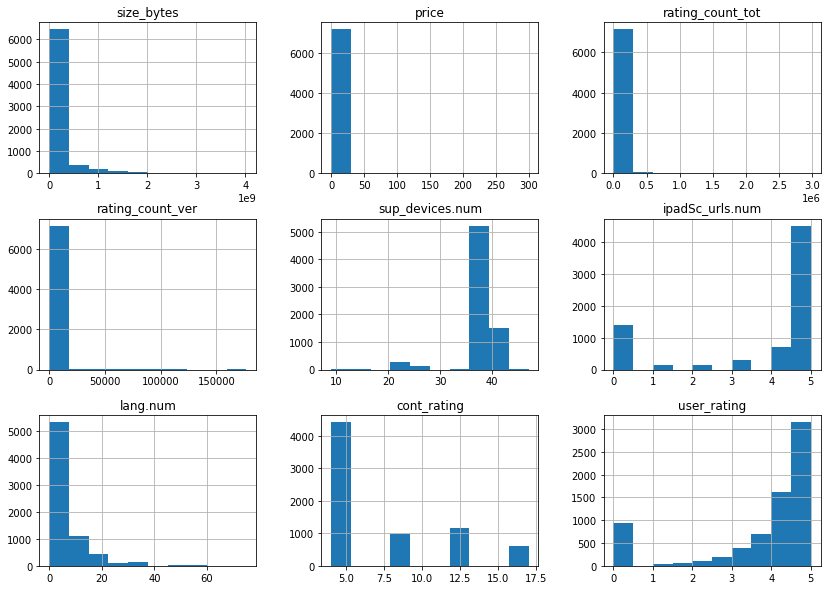

In [11]:
# Посмотрим на распредление величин
data.hist(column=num_cols+cat_cols+[target_col], figsize=(14, 10))
None

А теперь посмотрим на корреляции между фичами

In [12]:
data.corr().style.background_gradient(cmap='coolwarm').set_precision(2)

,size_bytes,price,rating_count_tot,rating_count_ver,sup_devices.num,ipadSc_urls.num,lang.num,cont_rating,user_rating
size_bytes,1.00,0.18,0.00,0.01,-0.12,0.15,0.00,0.14,0.07
price,0.18,1.00,-0.04,-0.02,-0.12,0.07,-0.01,-0.03,0.05
rating_count_tot,0.00,-0.04,1.00,0.16,0.01,0.02,0.14,0.01,0.08
rating_count_ver,0.01,-0.02,0.16,1.00,0.04,0.02,0.01,0.00,0.07
sup_devices.num,-0.12,-0.12,0.01,0.04,1.00,-0.04,-0.04,0.02,-0.04
ipadSc_urls.num,0.15,0.07,0.02,0.02,-0.04,1.00,0.09,-0.11,0.27
lang.num,0.00,-0.01,0.14,0.01,-0.04,0.09,1.00,-0.07,0.17
cont_rating,0.14,-0.03,0.01,0.00,0.02,-0.11,-0.07,1.00,-0.10
user_rating,0.07,0.05,0.08,0.07,-0.04,0.27,0.17,-0.10,1.00


И двойные графики

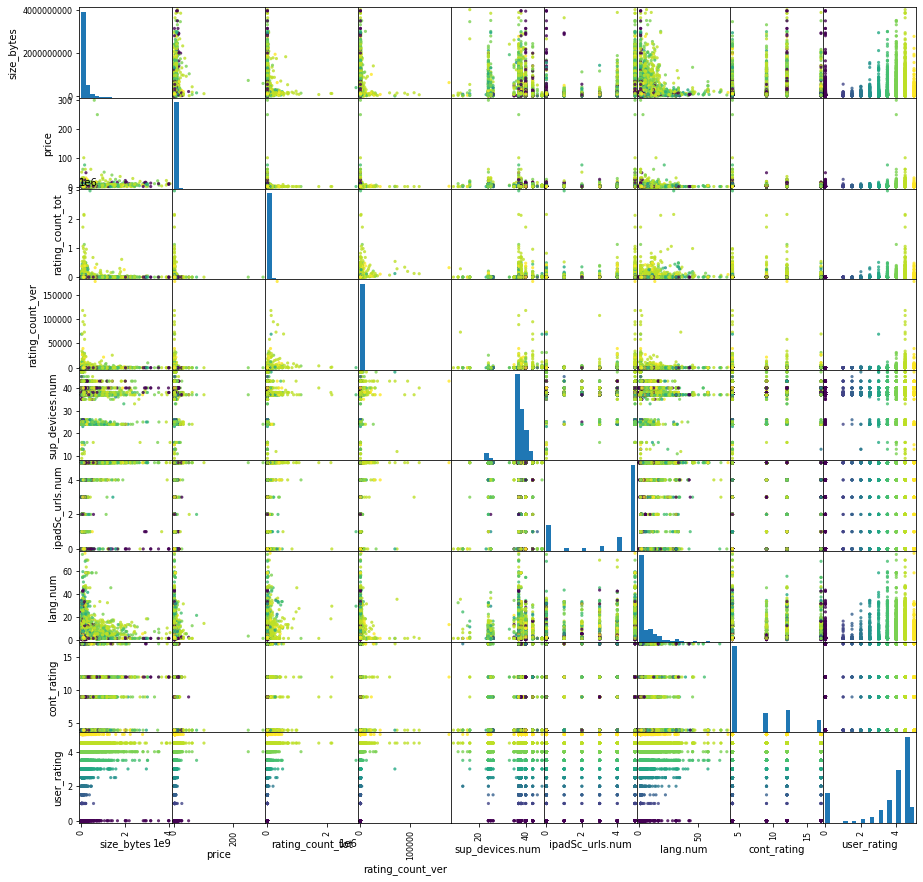

In [13]:
pd.plotting.scatter_matrix(data, c=data[target_col], figsize=(15, 15), marker='o',
                        hist_kwds={'bins': 20}, s=10, alpha=.8)
None

В данном случае фичей мало, поэтому мы легко смогли посмотреть на них. Обычно фичей намного больше и построить такие графики для пар фичей не получится. Тогда в первую очередь можно посмотреть на корреляцию фичей с таргетом.

## Подготовка данных

### Очистка

Данные достаточно чистые, в них вряд ли есть какие-то ошибки и не получается с первого взгляда найти выбросы (outliers). Поэтому и очищать особо нечего. Но в реальной жизни, ваши данные скорее всего будут полны мусора.

Чаще всего нам пришлось бы убирать выбросы, исправлять очевидные ошибки итд.


### Создание фичей

Чем сложнее зависимость между фичей и таргетом, тем более сложная модель потребуется, чтобы эту зависимость использовать. Почему бы просто не выбрать семейство самых гибких моделей? Проблема в том, что без большого количества данных для обучения будет происходить overfit. Это значит, что модель выучит зависимости, которые случайно появились в обучающих из-за ограниченного размера выборки. Такая модель будет хорошо работать на обучающей выборке, но будет плохо справляться с реальной задачей.

Используя человеческие знания об устройстве мира, мы можем упростить такую зависимость, создав новые фичи. На самом деле, можно даже не использовать человеческие знания, а просто применить какой-нибудь алгоритм. Например, если у нас есть фичи $x_1, x_2, ..., x_n$, то мы можем добавить новые фичи вида 
$$x_{newij} = x_i x_j, i \ne j$$
и понадеяться, что это улучшит предсказания

In [14]:
# Добавим категориальную фичу, которая говорит, бесплатное приложение или нет
data['is_free'] = data['price'] == 0
cat_cols.append('is_free')
data.head()

,size_bytes,price,rating_count_tot,rating_count_ver,sup_devices.num,ipadSc_urls.num,lang.num,cont_rating,prime_genre,user_rating,is_free
0,100788224,3.99,21292,26,38,5,10,4,Games,4.0,False
1,158578688,0.00,161065,26,37,5,23,4,Productivity,4.0,True
2,100524032,0.00,188583,2822,37,5,3,4,Weather,3.5,True
3,128512000,0.00,262241,649,37,5,9,12,Shopping,4.0,True
4,92774400,0.00,985920,5320,37,5,45,4,Reference,4.5,True


### Работа с категориальными признаками


Большинство алгоритмов не принимает категориальные фичи в чистом виде и нужно из как-то закодировать.

Очень небольшое число алгоритмов МО умеет работать с категориальными признаками в чистом виде. Например, это делает библиотека для градиентного бустинга от Яндекса catboost. Внтури она применяет разные эвристики для кодирования признаков в числа.

#### One-hot-encoding
Самый простой способ закодировать категориальные фичи - one hot encoding. Представьте, что у нас есть категориальная фича prime_genre с возможными значениями 
> ['Games', 'Entertainment', 'Education', 'Photo & Video']

мы можем создать 4 новые бинарные фичи для каждого из столбцов

> 'Entertaiment' -> [0, 1, 0, 0]

В pandas очень удобно использовать get_dummies для one-hot-encoding

In [15]:
a = pd.DataFrame.from_dict({'categorical': ['a', 'b', 'a', 'c']})
a

,categorical
0,a
1,b
2,a
3,c


In [16]:
pd.get_dummies(a)

,categorical_a,categorical_b,categorical_c
0,1,0,0
1,0,1,0
2,1,0,0
3,0,0,1


In [17]:
# Задание: Теперь добавьте в датафрейм колонки для всех категориальных фичей и обновите список категориальных фичей
data = pd.get_dummies(data, columns=cat_cols)

In [18]:
cat_cols_new = []
for col_name in cat_cols:
    cat_cols_new.extend(filter(lambda x: x.startswith(col_name), data.columns))
cat_cols = cat_cols_new

### Масштабирование признаков

Как мы говорили в лекции часто необходимо привести все признаки к одному масштабу. Для этого в sklearn есть специальный Transformer -- StandardScaler и MinMaxScaler.

StandardScaler во время .fit() для каждого признака $x_i$ считает среднее $\mu_i$ и стандартное отклонение $\sigma_i$ на обучающем датасете. Во время .transform() к каждому признаку применяется:

$$\mathbf{x_i}^{\text{new}} = \frac{\mathbf{x_i} - \mu_i}{\sigma_i}$$


MinMaxScaler во время .fit() для каждого признака $x_i$ считает минимум $x_{i, \text{min}}$ и максимум $x_{i, \text{max}}$ на обучающем датасете. Во время .transform() к каждому признаку применяется:

$$\mathbf{x_i}^{\text{new}} = \frac{\mathbf{x_i} - x_{i, \text{min}}}{x_{i, \text{max}} - x_{i, \text{min}}}$$

In [19]:
from sklearn.preprocessing import StandardScaler

pca = StandardScaler()
pca.fit(data[num_cols + cat_cols])
# Выход pca - numpy матрица, положим ее в новую переменную со всеми фичами
X = pca.transform(data[num_cols + cat_cols])

# Или есть более простой способ 
X = pca.fit_transform(data[num_cols + cat_cols])

## Разделение на train/test

После того, как мы обучили нашу модель нам нужно как-то понять, насколько она хорошо работает. Выше мы уже говорили про переобучение на данные, с которыми сеть обучалась. Из-за такого переобучения мы не сможем посчитать адекватно узнать точность предсказаний, если проверим точность на тех же данных, на которых обучались. Чтобы с этим бороться обучающую выборку обычно делят на две части train и test. На первой мы будем обучать модель, а на второй проверять, насколько хорошо модель работает. Размер тестовой выборки в 30-40% - неплохой выбор.

Иногда данных слишком мало, чтобы жертвовать ими на тестовую часть. Тогда применяется метод, который называет cross validation. Мы посмотрим на то, как он работает в секции про оценку модели.

**На самом деле, мы сделали не совсем правильно, потому что разделение на train/test нужно делать до добавления новых фичей/их кодирования итд. Иначе возможны лики из test части в train часть.** Например, при нормализации и PCA мы работаем со всем массивом данных, а значит информация из test попадет и в train. Но для упрощения кода и понимания того, что происходит мы не поделили выборку заранее. Если бы мы все-таки разделили выборку заранее, то нужно использовать fit на train части, а transform уже на обеих.

In [20]:
from sklearn.model_selection import train_test_split

In [21]:
# Задание: Загуглите как работает эта функция и поделите выборку на две части
X_train, X_test, y_train, y_test = train_test_split(X, data[target_col], test_size=0.2)

Хорошо, теперь можно обучить модели

## Обучение

Самый хороший способ - попробовать максимум разных алгоритмов, посмотреть, какой из них лучше справляется и уже по метрикам выбрать лучший (возможно, объединить предсказания с помощью стэкинга или блендинга, о которых будет на следующем занятии).

In [22]:
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score, mean_squared_error

Поговорим про метрики. Метрика это, так же как и функция потерь, какая-то функция, показывающая насколько хорошо работает наша модель. Например, любой лосс можно назвать метрикой. Но не любую метрику можно назвать лоссом: лосс это именно то число, которое мы уменьшаем в процессе обучения модели + для лосса всегда верно, что чем он меньше, тем лучше. Метрики нужны как раз для того, чтобы оценивать работу алгоритма с помощью числа, которое он не учился напрямую минимизировать.

Для классификации наиболее простой метрикой будет являться точность или accuracy (доля совпавших предсказаний и настоящих классов). Она никогда не используется внутри лоссов, потому что нет эффективного алгоритма, который бы позволил ее обучать модели с такой функцией потерь.

В данном случае у нас задача регрессии, поэтому мы используем две метрики MSE и R_squared. 

$$R^2 = 1 - \frac{\sum_{i=1}^{n} (y^i - y_{pred}^i)^2}{\sum_{i=1}^{n} (y^i - y_{mean})^2}$$

R_aquared это доля объясненной вариации. R_squared = 1, когда у нас есть идеальный предсказатель. R_squared = 0 достигает модель, которая просто выдает в качестве ответа среднее Значение целевой переменной. А значения меньше 0 говорят о том, что модель хуже константного предсказателя.

In [23]:
def print_metrics(y_preds, y):
    print(f'R^2: {r2_score(y_preds, y)}')
    print(f'MSE: {mean_squared_error(y_preds, y)}')

In [24]:
# Используем обычную линейную регрессию, минимизирующую сумму квадратов ошибки
lr = LinearRegression()
lr.fit(X_train, y_train)

print_metrics(lr.predict(X_test), y_test)

R^2: -5.093442730468119
MSE: 2.054460372699674


In [25]:
# Используем обычную линейную регрессию, минимизирующую сумму квадратов ошибки
knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train, y_train)

print_metrics(knn.predict(X_test), y_test)

R^2: -1.0512321251855625
MSE: 2.019152777777778


**Задание:** поиграйтесь с гиперпараметрами и улучшите предсказания моделей.

## Cross Validation

До этого мы разбирали случай, когда выборка заранее делится на train/test, но часто данных итак не хватает и отдавать их часть на test слишком расточительно. В такой ситуации на помощью приходит кросс валидация:
1. Выберем $k$ - количество частей, на которые разобьется наш датасет
2. for $ i = 1..k$ 
    * Обучим модель на всех частях датасета, кроме i-ой.
    * Посчитаем метрики или предсказания для i-ой части
3. Саггрегируем все все предсказания или усредним метрики

Таким образом мы сможем получить более объективные предсказания нашей модели, использовав весь датасет как train и как test, при этом не создав утечек данных.

В sklearn существуют уже готовые классы моделей, которые за нас проводят все вышеописанные действия. Но у них есть один минус - выше мы уже писали, что лики могут произойти еще на этапе обработки данных. Избежать этого при ручной разбивке датасета легко, но в случае кросс валидации придется либо сдлеать специальный объект Pipeline, в котором будет скрыта вся обработка данных, и sklearn просто вызовет его $k$ раз, либо руками выбирать индексы объектов с помощью класса KFold и самостоятельно обрабатывать данные. Мы не будем делать ни то, ни другое, но покажем, как это может быть реализовано.

Получим из кроссвалидации метрики

In [26]:
from sklearn.metrics import r2_score, mean_squared_error, make_scorer
from sklearn.model_selection import cross_validate

In [27]:
cross_validate(LinearRegression(), X, data[target_col], cv=5, 
               scoring={'r2_score': make_scorer(r2_score), 
                        'mean_squared_error': make_scorer(mean_squared_error)})

{'fit_time': array([0.01731586, 0.01834559, 0.02072072, 0.01951861, 0.02119827]),
 'score_time': array([0.00616264, 0.00319362, 0.00318313, 0.00138235, 0.00331974]),
 'test_mean_squared_error': array([1.64762977, 1.48911162, 1.94016043, 2.81765419, 2.93208346]),
 'test_r2_score': array([-0.81063206,  0.06525657,  0.11584947,  0.10988879,  0.07104699])}

In [28]:
cross_validate(KNeighborsRegressor(), X, data[target_col], cv=5, 
               scoring={'r2_score': make_scorer(r2_score, ), 
                        'mean_squared_error': make_scorer(mean_squared_error)})

{'fit_time': array([0.0730238 , 0.02813864, 0.03439403, 0.03555822, 0.03245544]),
 'score_time': array([0.23748565, 0.37252736, 0.29781055, 0.27485299, 0.26141429]),
 'test_mean_squared_error': array([1.45365278, 1.60641667, 2.13405142, 2.5614385 , 2.91881167]),
 'test_r2_score': array([-0.59746466, -0.00837802,  0.0274914 ,  0.19082863,  0.0752518 ])}

## GridSearchCV
А еще с помощью кросс валидации можно искать гиперпараметры.

In [29]:
from sklearn.model_selection import GridSearchCV

In [30]:
gbr_grid_search = GridSearchCV(KNeighborsRegressor(), 
                               [{'n_neighbors': [1, 2, 3, 4, 6, 8, 10, 15]}],
                               cv=5,
                               error_score=make_scorer(mean_squared_error),
                               verbose=10)
gbr_grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] n_neighbors=1 ...................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ...................... n_neighbors=1, score=-0.329, total=   0.3s
[CV] n_neighbors=1 ...................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV] ...................... n_neighbors=1, score=-0.450, total=   0.3s
[CV] n_neighbors=1 ...................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s


[CV] ...................... n_neighbors=1, score=-0.467, total=   0.3s
[CV] n_neighbors=1 ...................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.8s remaining:    0.0s


[CV] ...................... n_neighbors=1, score=-0.323, total=   0.3s
[CV] n_neighbors=1 ...................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    1.1s remaining:    0.0s


[CV] ...................... n_neighbors=1, score=-0.254, total=   0.3s
[CV] n_neighbors=2 ...................................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.4s remaining:    0.0s


[CV] ...................... n_neighbors=2, score=-0.039, total=   0.3s
[CV] n_neighbors=2 ...................................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    1.7s remaining:    0.0s


[CV] ...................... n_neighbors=2, score=-0.142, total=   0.3s
[CV] n_neighbors=2 ...................................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    2.0s remaining:    0.0s


[CV] ...................... n_neighbors=2, score=-0.119, total=   0.3s
[CV] n_neighbors=2 ...................................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    2.3s remaining:    0.0s


[CV] ....................... n_neighbors=2, score=0.001, total=   0.3s
[CV] n_neighbors=2 ...................................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    2.5s remaining:    0.0s


[CV] ....................... n_neighbors=2, score=0.036, total=   0.3s
[CV] n_neighbors=3 ...................................................
[CV] ....................... n_neighbors=3, score=0.063, total=   0.3s
[CV] n_neighbors=3 ...................................................
[CV] ...................... n_neighbors=3, score=-0.057, total=   0.3s
[CV] n_neighbors=3 ...................................................
[CV] ....................... n_neighbors=3, score=0.016, total=   0.3s
[CV] n_neighbors=3 ...................................................
[CV] ....................... n_neighbors=3, score=0.078, total=   0.3s
[CV] n_neighbors=3 ...................................................
[CV] ....................... n_neighbors=3, score=0.128, total=   0.3s
[CV] n_neighbors=4 ...................................................
[CV] ....................... n_neighbors=4, score=0.109, total=   0.3s
[CV] n_neighbors=4 ...................................................
[CV] .

[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:   12.4s finished


GridSearchCV(cv=5, error_score=make_scorer(mean_squared_error),
             estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30,
                                           metric='minkowski',
                                           metric_params=None, n_jobs=None,
                                           n_neighbors=5, p=2,
                                           weights='uniform'),
             iid='deprecated', n_jobs=None,
             param_grid=[{'n_neighbors': [1, 2, 3, 4, 6, 8, 10, 15]}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=10)

In [31]:
print(gbr_grid_search.best_params_)
print(gbr_grid_search.best_score_)
print(gbr_grid_search.best_estimator_)

{'n_neighbors': 15}
0.17109887318789876
KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=15, p=2,
                    weights='uniform')


## Vanilla KFold

In [32]:
from sklearn.model_selection import KFold

In [33]:
kf = KFold(n_splits=5)

In [34]:
model = KNeighborsRegressor()

In [35]:
metrics = []
for train_ind, test_ind in kf.split(X_train):
    model.fit(X_train[train_ind], y_train.values[train_ind])
    pred = model.predict(X_train[test_ind])
    metrics.append(mean_squared_error(y_train.values[test_ind], pred))

In [36]:
metrics

[2.0367968750000003,
 2.0195572916666666,
 2.0256733275412686,
 2.043197219808862,
 1.9107211120764551]